In [256]:
# import libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import re
import random
import nltk
from scipy import sparse
from scipy.sparse import csr_matrix, vstack
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

from langdetect import detect_langs
import pickle
from datetime import datetime
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift
from sklearn import preprocessing

In [2]:
#nltk.download('movie_reviews')
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('stopwords')

In [203]:
song_df = pd.read_csv(r'C:\Users\MCOSKUN\songdata.csv')
song_df.drop('link', axis =1 , inplace = True)
song_df.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [204]:
# remove round brackets but not text within
song_df['text'] = song_df['text'].map(lambda s: re.sub(r'\(|\)', '', s))

# remove square brackest and text within
song_df['text'] = song_df['text'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

In [4]:
# count number of lines
song_df['lines'] = song_df['text'].map(lambda t: len(re.findall(r'\n', t)))
# remove line breaks
song_df['text'] = song_df['text'].map(lambda s: re.sub(r' \n|\n', '', s))

In [5]:
def get_eng_prob(text):
    detections = detect_langs(text)
    for detection in detections:
        if detection.lang == 'en':
            return detection.prob
    return 0

song_df['en_prob'] = song_df['text'].map(get_eng_prob)

print('Number of english songs: {}'.format(sum(song_df['en_prob'] >= 0.5)))
print('Number of non-english songs: {}'.format(sum(song_df['en_prob'] < 0.5)))

Number of english songs: 57183
Number of non-english songs: 467


In [6]:
song_df = song_df.loc[song_df['en_prob'] >= 0.5]

In [205]:
#song_df.to_csv(r'C:\Users\MCOSKUN\songdata-en.csv')
song_df = pd.read_csv(r'C:\Users\MCOSKUN\songdata-en.csv', index_col = 'artist')
song_df.drop('Unnamed: 0', axis = 1, inplace = True)

# Grouping

In [206]:

lemmatizer = WordNetLemmatizer()

song_df['lemmatization'] = song_df['tokens'].apply(lambda x: lemmatizer.lemmatize(x))

In [207]:
song_df['lemmatization_str'] = song_df['lemmatization'].map(lambda lst: ' '.join(lst))

In [208]:
song_df['lemmatization_str'] = song_df['lemmatization_str'].str.replace(r' ', '')


# Remove stop words and group

In [209]:
song_df_grouped = song_df.groupby('artist')['lemmatization'].sum()
song_df_grouped = pd.DataFrame(data = song_df_grouped, index = song_df_grouped.index)
song_df_grouped

,lemmatization
artist,
'n Sync,"['Girl', 'don', 't', 'say', 'that', 'it', 's',..."
ABBA,"['Look', 'at', 'her', 'face', 'it', 's', 'a', ..."
Ace Of Base,"['Always', 'have', 'always', 'will', 'I', 'was..."
Adam Sandler,"['Hello', 'mudda', 'hello', 'fadda', 'Here', '..."
Adele,"['I', 'will', 'leave', 'my', 'heart', 'at', 't..."
...,...
Zoegirl,"['I', 've', 'been', 'thinking', 'lately', 'abo..."
Zornik,"['Is', 'a', 'dream', 'a', 'lie', 'when', 'you'..."
Zox,"['If', 'I', 'could', 'write', 'you', 'a', 'son..."


In [191]:
#song_df_grouped.to_csv(r'C:\Users\MCOSKUN\discography-sentiments.csv')
song_df_grouped = pd.read_csv(r'C:\Users\MCOSKUN\discography-sentiments.csv')

In [ ]:
import ast
for row in range(len(song_df_grouped['lemmatization'])):
    l = ast.literal_eval(song_df_grouped['lemmatization'][row])
    l = [i.strip() for i in l]
    song_df_grouped['lemmatization'][row] = l

In [47]:
stop_words = set(stopwords.words('english')) 

for w in song_df_grouped['lemmatization']: 
    for z in w:
        if z in stop_words: 
            for item in w:
                if(item==z):
                    w.remove(z)

,lemmatization
artist,
'n Sync,"[Girl, say, Cause, part, yeah, Girl, hold, ple..."
ABBA,"[Look, face, wonderful, face, And, means, some..."
Ace Of Base,"[Always, always, I, mesmerized, I, first, met,..."
Adam Sandler,"[Hello, mudda, hello, fadda, Here, I, camp, gr..."
Adele,"[I, leave, heart, door, I, say, word, They, sa..."
...,...
Zoegirl,"[I, thinking, lately, When, hit, nowhere, Out,..."
Zornik,"[Is, dream, lie, know, won, come, true, And, I..."
Zox,"[If, I, could, write, song, With, right, words..."


In [184]:
counter = 0
song_df_grouped['lemmatization_freq'] = song_df_grouped['lemmatization']
for w in song_df_grouped['lemmatization']: 
    word_counter = dict()
    for a in w:
        if a in word_counter:
            word_counter[a] += 1
        else:
            word_counter[a] = 1
    song_df_grouped.iloc[counter].at['lemmatization_freq'] = sorted(word_counter, key = word_counter.get, reverse = True)[:50]
    counter += 1

In [160]:
i = 0
l1 = list()
l2 = list()

for artist_sent in song_df_grouped.index:

    l1.append(TextBlob(str(song_df_grouped.iloc[i]['lemmatization_freq'])).sentiment.polarity)
    l2.append(TextBlob(str(song_df_grouped.iloc[i]['lemmatization_freq'])).sentiment.subjectivity)
    
    i += 1
song_df_grouped['c'] = l1
song_df_grouped['Sentiment_Subjectivity'] = l2

In [269]:
#song_df_grouped.drop(['Sentiment_Positive','Sentiment_Negative','Sentiment_Neutral'], axis = 1, inplace = True)

#song_df_grouped.to_excel(r'C:\Users\MCOSKUN\df-grouped-discography.xlsx')
song_df_grouped = pd.read_excel(r'C:\Users\MCOSKUN\df-grouped-discography.xlsx')

In [270]:
# number of unique stems
song_df_grouped['n_unique_lemms'] = song_df_grouped['lemmatization'].map(lambda lst: len(set(lst)))
song_df_grouped['n_unique_lemms'] = preprocessing.scale(song_df_grouped['n_unique_lemms'])


In [271]:
song_df_grouped[song_df_grouped['Sentiment_Subjectivity'] < 0.4]

,artist,Genre,lemmatization,Sentiment_Polarity,Sentiment_Subjectivity,lemmatization_freq,n_unique_lemms
78,Creedence Clearwater Revival,Rock,"['I', 'see', 'bad', 'moon', 'rising', 'I', 'se...",0.152967,0.368655,"['I', 'see', 'bad', 'moon', 'rising', 'I', 'se...",0.057127
174,Gipsy Kings,Pop,"['To', 'side', 'To', 'side', 'always', 'verita...",-0.066667,0.266667,"['To', 'side', 'To', 'side', 'always', 'verita...",-5.746566
431,Raffi,Pop,"['Baby', 'beluga', 'deep', 'blue', 'sea', 'Swi...",0.115914,0.372545,"['Baby', 'beluga', 'deep', 'blue', 'sea', 'Swi...",-0.175020
556,Walk The Moon,Pop,"['Screen', 'falling', 'door', 'door', 'hanging...",0.087765,0.398407,"['Screen', 'falling', 'door', 'door', 'hanging...",-0.639316


In [274]:
song_df_grouped[song_df_grouped['Sentiment_Polarity'] > 0.32]

,artist,Genre,lemmatization,Sentiment_Polarity,Sentiment_Subjectivity,lemmatization_freq,n_unique_lemms
102,Don Moen,Pop,"['All', 'like', 'sheep', 'Have', 'gone', 'astr...",0.338496,0.543239,"['All', 'like', 'sheep', 'Have', 'gone', 'astr...",-0.639316
226,Iron Butterfly,Rock,"['Most', 'anything', 'want', 'girl', 'Is', 'al...",0.376092,0.593715,"['Most', 'anything', 'want', 'girl', 'Is', 'al...",-1.800055
586,X-Treme,Metal,"['This', 'love', 'song', 'To', 'make', 'dreams...",0.450000,0.616667,"['This', 'love', 'song', 'To', 'make', 'dreams...",-6.443010
628,Zed,Pop,"['It', 'alright', 'It', 'Ok', 'I', 'keep', 'ho...",0.322222,0.569444,"['It', 'alright', 'It', 'Ok', 'I', 'keep', 'ho...",-4.121532


In [265]:
song_df_grouped = song_df_grouped[song_df_grouped['Sentiment_Subjectivity'] > 0.4]
song_df_grouped = song_df_grouped[song_df_grouped['Sentiment_Polarity'] < 0.32]

In [246]:
song_df_grouped.groupby(["Genre"])["Sentiment_Polarity"].mean()

Genre
Metal    0.040333
Pop      0.152149
Rap      0.061059
Rock     0.099764
Name: Sentiment_Polarity, dtype: float64

In [247]:
song_df_grouped.groupby(["Genre"])["Sentiment_Subjectivity"].mean()

Genre
Metal    0.515911
Pop      0.521720
Rap      0.501154
Rock     0.505254
Name: Sentiment_Subjectivity, dtype: float64

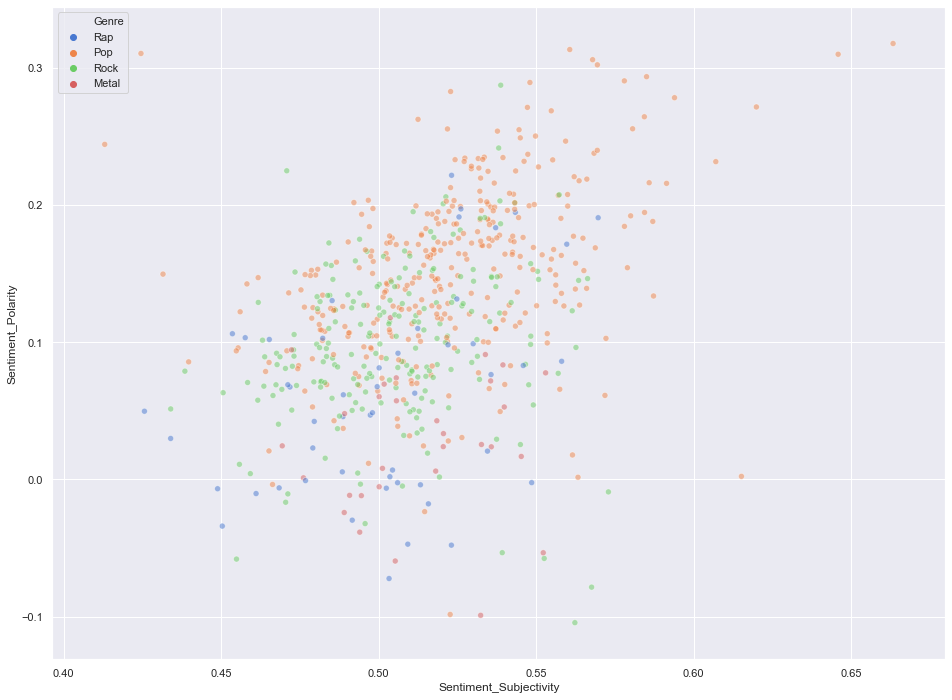

In [266]:
import seaborn as sns
sns.set_context("poster")
sns.set(style="whitegrid")

sns.set(rc={'figure.figsize':(16,12)})

sns.scatterplot(x="Sentiment_Subjectivity", y="Sentiment_Polarity", hue="Genre",
                palette="muted",alpha=.5, data=song_df_grouped)

In [260]:
song_df_grouped.groupby(["Genre"])["n_unique_lemms"].mean()

Genre
Metal   -0.234930
Pop     -0.183095
Rap      0.953855
Rock     0.103337
Name: n_unique_lemms, dtype: float64